In [ ]:
'''

This notebook does the following experiment - 
    1. Take a word as input
    2. Scrape its wiki page online
    3. Find first 3 word links(excluding the parent word) from the page
    4. Scrape the pages of those 3 words
    5. Repeat step 3
    6. End after a certain number of words have been encountered


'''

In [79]:
from bs4 import BeautifulSoup
import networkx as nx
import warnings
import requests
import re
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
from nltk.stem import PorterStemmer
from collections import OrderedDict

In [70]:
def check_url_text(url,text,tracker):
    
    text =  re.sub('[^a-zA-Z0-9\s]',' ',text).strip().lower()
    
    bad_words = ['jump to','help','wiki','wik','sister projects','free','online dictionary','references',
                 'log','sign','commons','redirect','news','newspaper','books','scholar','JSTOR','jstor','case sensitive',
                 'article','create','contributions','talk','main page','edit','contents','donate','contact us']
        
    if 'disambiguation' in text or 'verification' in text:
        return False
    
    elif len(text.split(' ')) > 2:
        return False
    
    elif 'cite' in url or 'citation' in url:
        return False
    
    elif len(text) == 0:
        return False
    
    elif text.isnumeric():
        return False
    
    elif any(w in text for w in bad_words) is True:
        return False

    elif text in tracker or text.lower() in tracker:
        return False
    
    else:
        return text



def start_scraping(entry_word,nodes=3,skip=10,depth=10):
    
    
    if entry_word is None or len(entry_word) == 0:
        raise ValueError('Please enter a non empty string')
   
    result = OrderedDict()
    while len(result) != depth:
       
        base_url = f'https://en.wikipedia.org/wiki/{entry_word}'
        response = requests.get(base_url)
        soup = BeautifulSoup(response.content,'html.parser')

        links = soup.find_all('a',href=True)
        skip = 0 if skip >= len(links) else skip
        neighbors = []
        for link in links[skip:]:
            try:
                url = link['href']
                text = link.text
                res = check_url_text(url,text,result.keys())
                if res:
                    neighbors.append(res)
            except:
                continue
            
            if len(neighbors) == nodes:
                break

        
        #print(neighbors)
        result[entry_word] = neighbors.copy() # to prevent pop operation from affecting this
        entry_word = neighbors.pop(0)
    
    return result

In [82]:
result = start_scraping('india')

In [83]:
graph = nx.DiGraph(result)

In [84]:
graph.nodes()

NodeView(('india', 'satyameva jayate', 'gujarati', 'gujarati cuisine', 'punjabi', 'kurta', 'south asia', 'gdp', 'history', 'romanized', 'sanskrit', 'vande mataram', 'hindi', 'kannada', 'gujarati culture', 'gujari language', 'rajasthani', 'uttar pradeshi', 'timmy trumpet', 'archie panjabi', 'central asian', 'tunics', 'ethnic groups', 'indo aryan', 'outline', 'index', 'lit', 'past', 'simplified chinese', 'hanyu pinyin', 'gwoyeu romatzyh'))

In [85]:
graph.edges()

OutEdgeView([('india', 'satyameva jayate'), ('india', 'sanskrit'), ('india', 'vande mataram'), ('satyameva jayate', 'gujarati'), ('satyameva jayate', 'hindi'), ('satyameva jayate', 'kannada'), ('gujarati', 'gujarati cuisine'), ('gujarati', 'gujarati culture'), ('gujarati', 'gujari language'), ('gujarati cuisine', 'punjabi'), ('gujarati cuisine', 'rajasthani'), ('gujarati cuisine', 'uttar pradeshi'), ('punjabi', 'kurta'), ('punjabi', 'timmy trumpet'), ('punjabi', 'archie panjabi'), ('kurta', 'south asia'), ('kurta', 'central asian'), ('kurta', 'tunics'), ('south asia', 'gdp'), ('south asia', 'ethnic groups'), ('south asia', 'indo aryan'), ('gdp', 'history'), ('gdp', 'outline'), ('gdp', 'index'), ('history', 'romanized'), ('history', 'lit'), ('history', 'past'), ('romanized', 'simplified chinese'), ('romanized', 'hanyu pinyin'), ('romanized', 'gwoyeu romatzyh')])

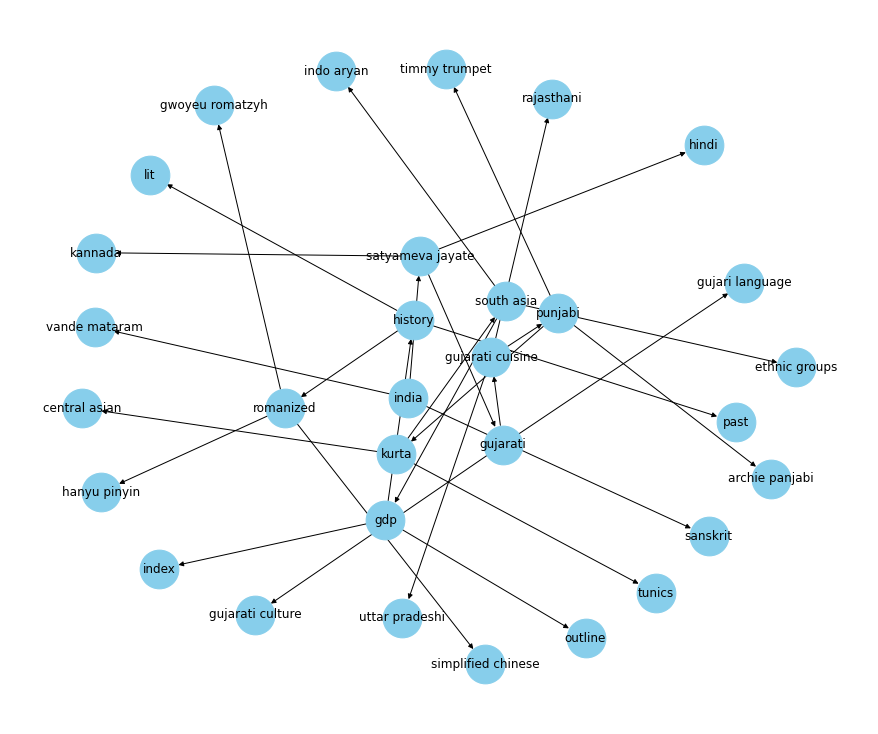

In [86]:
plt.figure(figsize=(12,10))
pos = nx.spring_layout(graph,k=0.5)
nx.draw(graph, with_labels=True, node_color='skyblue', edge_cmap=plt.cm.Blues, pos = pos,node_size=1500)
plt.show()